# Simple Neural Network - XOR

## Code adapted from 
- https://github.com/phlippe/uvadlc_notebooks/tree/master/docs/tutorial_notebooks/tutorial2

Initializers
* `torch.zeros`: Creates a tensor filled with zeros
* `torch.ones`: Creates a tensor filled with ones
* `torch.rand`: Creates a tensor with random values uniformly sampled between 0 and 1
* `torch.randn`: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
* `torch.arange`: Creates a tensor containing the values $N,N+1,N+2,...,M$
* `torch.tensor` (input list): Creates a tensor from the list elements you provide

In [ ]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

In [6]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# print("Device", device)
# torch.cuda.manual_seed(42)
# torch.cuda.manual_seed_all(42)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")
print("Device", device)
torch.mps.manual_seed(42)

Device mps


In [7]:
class SimpleClassifier(nn.Module):

    def __init__(self, num_inputs, num_hidden, num_outputs, act_fn = nn.Tanh()):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = act_fn
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [8]:
# Goodfellow example
xs = torch.tensor([[-1, -1], [-1, 1], [1, -1], [1, 1]], dtype = torch.float32).to(device)
ys = torch.tensor([1, 0, 0, 1], dtype = torch.float32).to(device)
loss_module = nn.BCEWithLogitsLoss()

In [9]:
# Can't predict without non-linearity
torch.manual_seed(1)
model = SimpleClassifier(2, 10, 1, nn.Identity()) # We increase hidden units to 10 and we still can't predict, as expected
model.to(device)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
for epoch in range(100):
    preds = model(xs).reshape(-1,)
    loss = loss_module(preds, ys)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Loss: {np.round(loss.item(), 3)}", f"Acc: {(torch.sum((preds > 0) == ys)/ys.size()[0]).cpu().item()}")

Loss: 0.703 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5
Loss: 0.693 Acc: 0.5


In [10]:
torch.manual_seed(1)
model = SimpleClassifier(2, 2, 1, nn.ReLU())
model.to(device)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
for epoch in range(50):
    preds = model(xs).reshape(-1,)
    loss = loss_module(preds, ys)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Loss: {np.round(loss.item(), 3)}", f"Acc: {(torch.sum((preds > 0) == ys)/ys.size()[0]).cpu().item()}")

Loss: 0.705 Acc: 0.5
Loss: 0.685 Acc: 0.5
Loss: 0.647 Acc: 0.75
Loss: 0.562 Acc: 0.75
Loss: 0.511 Acc: 0.75
Loss: 0.468 Acc: 0.75
Loss: 0.41 Acc: 0.75
Loss: 0.329 Acc: 0.75
Loss: 0.265 Acc: 1.0
Loss: 0.202 Acc: 1.0


In [11]:
def get_coords(tensor):
    return tensor.cpu().numpy()[:,0], tensor.cpu().numpy()[:,1]

xs = np.tile(np.arange(-1, 1.1, 0.2),11)
ys = np.repeat(np.arange(-1,1.1,0.2), 11)
with torch.no_grad():
    coords_l1 = model.linear1(torch.tensor(np.c_[xs, ys], dtype = torch.float32).to(device))
    xs_l1, ys_l1 = get_coords(coords_l1)
    xs_l1_relu, ys_l1_relu = get_coords(nn.ReLU()(coords_l1))

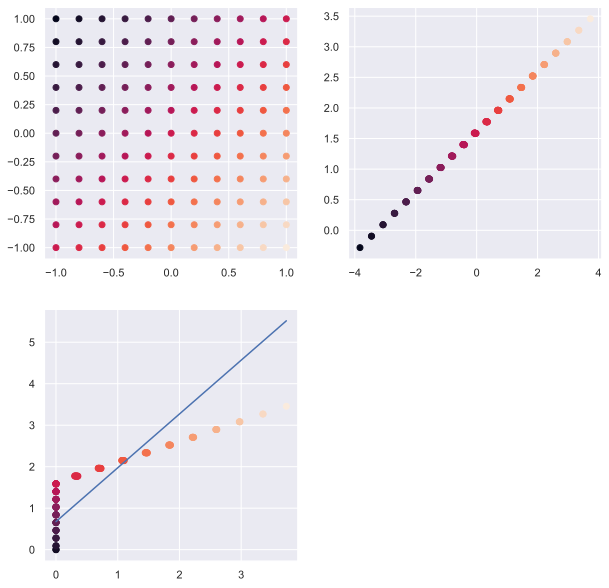

In [12]:
fig, axs = plt.subplots(2, 2, figsize = (10,10))
axs[0][0].scatter(xs, ys, c = xs-ys)
axs[0][1].scatter(xs_l1, ys_l1, c = xs-ys)
axs[1][0].scatter(xs_l1_relu, ys_l1_relu, c = xs-ys)
axs[1][0].plot(xs_l1_relu, xs_l1_relu*(-model.linear2.weight[0][0]/model.linear2.weight[0][1]).detach().cpu().numpy() - model.linear2.bias.detach().cpu().numpy())
fig.delaxes(axs[1][1])
plt.show()

In [13]:
class XORDataset(data.Dataset):

    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [14]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        for data_inputs, data_labels in data_loader:
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.reshape(-1,)
            loss = loss_module(preds, data_labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [15]:
def eval_model(model, data_loader):
    model.eval() 
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): 
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            pred_labels = (torch.sigmoid(preds) > 0.5).int().reshape(-1)
            true_preds += (pred_labels == data_labels).sum().float()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [16]:
torch.manual_seed(1)
loss_module = nn.BCEWithLogitsLoss()
train_dataset = XORDataset(size=2500)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = XORDataset(size=500)
test_data_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_model(model, optimizer, train_data_loader, loss_module)

# Save model
state_dict = model.state_dict()
print(state_dict)
# torch.save(state_dict, "our_model.tar")
# state_dict = torch.load("our_model.tar")
# new_model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# new_model.load_state_dict(state_dict)

eval_model(model, test_data_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

OrderedDict({'linear1.weight': tensor([[-0.6186, -1.2413],
        [ 2.4791,  2.3084],
        [-1.9578,  2.8000],
        [ 3.2432, -2.6608]], device='mps:0'), 'linear1.bias': tensor([ 1.3746, -0.7270,  0.7655,  1.2364], device='mps:0'), 'linear2.weight': tensor([[ 2.0459,  3.4998, -3.6495, -4.2671]], device='mps:0'), 'linear2.bias': tensor([0.8146], device='mps:0')})
Accuracy of the model: 100.00%


/opt/anaconda3/lib/python3.12/site-packages/torch/_tensor_str.py:145: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/aten/src/ATen/native/mps/operations/Indexing.mm:361.)
  nonzero_finite_vals = torch.masked_select(


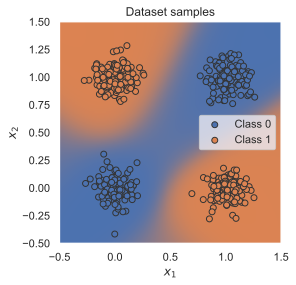

In [17]:
@torch.no_grad() # Decorator
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(model, test_dataset.data, test_dataset.label)
plt.show()

# Linear and Softmax Regression with d2l packages

## Code adapted from 
- http://d2l.ai/chapter_linear-regression/linear-regression-concise.html

In [5]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

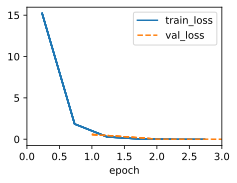

In [3]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [4]:
@d2l.add_to_class(LinearRegression)  
def get_w_b(self):
    return (self.net.weight.data, self.net.bias.data)
w, b = model.get_w_b()

print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

error in estimating w: tensor([ 0.0071, -0.0089])
error in estimating b: tensor([0.0099])


In [187]:
class SoftmaxRegression(d2l.Classifier):  #@save
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(num_outputs))

    def forward(self, X):
        return self.net(X)

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        Y = Y.reshape((-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')
        # Equivalent to this
        # return -torch.log(torch.softmax(Y_hat, dim = -1))[list(range(Y_hat.shape[0])), Y].mean()

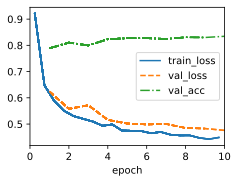

In [188]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# BatchNorm

Importantly, we define the function outside the class, and call it for readability

In [1]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use is_grad_enabled to determine whether we are in training mode
    if not torch.is_grad_enabled():
        # In prediction mode, use mean and variance obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of X, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = (1.0 - momentum) * moving_mean + momentum * mean
        moving_var = (1.0 - momentum) * moving_var + momentum * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

In [2]:
class BatchNorm(nn.Module):
    # num_features: the number of outputs for a fully connected layer or the
    # number of output channels for a convolutional layer. num_dims: 2 for a
    # fully connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and
        # 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If X is not on the main memory, copy moving_mean and moving_var to
        # the device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.1)
        return Y

NameError: name 'nn' is not defined